In [52]:
import re
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sympy as sp
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
#nltk.download('punkt')
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

### Methodology:

The goal of this notebook is to apply the Singular Value Decomposition (SVD) to text data. This technique is known as Latent Semantic Analysis (LSA). In order to show my audience the impact of this method I chose two extremely different article categories to analyze: 3 essays/articles about Trump's Immigration policy and a blog about St. Patrick's Day team bonding activities. 

#### Reviewing the Singular Value Decomposition (SVD)

The SVD can decompose **any** matrix A (real or compelx) into three matrices, U, ∑, V. U and V are orthonormal and ∑ is diagonal. We do this decomposition by doing A^T * A and A * A^T. When we multiply A^T * A or A * A^T we can turn a potentially rectangular matrix of data into a **square matrix.** This is helpful because we can now analyze what's happening in this matrix using eigenvectors and eigenvalues. This is *because* our matrix is square. Remember that we can only take eigenthings of square matrices. 

Furthermore when we decompose A into three matrices the entries of U and V are the eigenvectors of A * A^T and A^T * A, respectively. The eigenvalues are the **same** between these two matrices. One of the important facts in linear algebra is BA and AB have the same non-zero eigenvalues. This is because their "characteristic polynomial" is the same. The eigenvalues are in ∑ and are ordered in descending order. 

You may be wondering *how* we know the matrices U and V are orthonormal or what the sign of the eigenvalues is (or whether they are real or complex!). We know these properties because of the spectral theorem. When we multiply A * A^T (or A^T * A) we get a symmetric, positive definite matrix. Let's talk about symmetric matrices first. Recall the definition of a symmetric matrix is A^T = A. We **know** we get a symmetric matrix because we are multiplying the transpose by itself. We can prove this to ourself by doing matmul. Now, the [spectral theorem](https://www.youtube.com/watch?v=UCc9q_cAhho&pp=ygUdc3ltbWV0cmljIG1hdHJpY2VzIGdpbCBzdHJhbmc%3D) states that for symmetric matrices the eigenvectors are orthogonal and the eigenvalues are real. See the link for a proof. 

Positive definiteness is the second property from above. This guarantees that all the eigenvalues are positive, not just real. We know a matrix is positive definite by a few properties. If all the pivots are positive, if all the eigenvalues are positive, if all the upper left determinants are positive, if x^T * A * x > 0, or if A = R^T * R where R has independent columns. We can takeaway that it's much harder to check for positive definiteness than it is for symmetry (you can just look at the matrix or use `np.transpose(A)` and `assert np.transpose(A) == A`. In the practice problems I've done on 1x1 to 4x4 matrices I have found it simplest to calculate the "sub-determinants" of the matrix. If you are more curious about proofs of these properties see [this link](https://www.math.utah.edu/~zwick/Classes/Fall2012_2270/Lectures/Lecture33_with_Examples.pdf). So, to connect this to our A^T * A and A * A^T multiplication, these properties hold for those matrices and we can confirm them by any of the five methods. That's important -- the proof is an equivalence proof. If we have one of these properties we have **all** of them. 

Two more things: (1) Because the SVD has orthonormal vectors it gives us the **best basis** when we are reconstructing the matrix A. By best I mean we have completely independent axes that represent our column vectors of A. (2) We can decompose the matrix A into a sum of products of rank-one matrices from the SVD. When we multiply rank one matrices we call this an "outer product" which is row vector * column vector (x^T * x). We call this rank one because the resulting matrix of this row-column vector multiplication will give us a matrix where the row and column entries are multiplies of the first row/first column. I think fact is important to give us another perspective on how we can write the matrix A. Later on in this lesson we'll relate the sum of products of rank-one matrices to low-rank approximations.

#### More notes on methodology

In order to get the data for this analysis I scraped three Trump articles of various lengths (2 from Substack authors and one from CNBC) and one St. Patrick's Day blog. I tokenized each of the sentences using `nltk` and concatenated the sentences from all the articles into a dataframe called `concat_df`. These sentences in the language of Latent Semantic Analysis (LSA) are called documents. I'll refer to them as such for the rest of the notebook. 

In [2]:
response = requests.get('https://thepreamble.com/p/trump-promised-the-biggest-deportation')
soup = BeautifulSoup(response.content, 'html.parser')

p_tags_article1 = soup.find_all(lambda tag: tag.name == 'p' and not tag.find_parent(class_="sideBySideWrap-vGXrwP"))
clean_text_article1 = [el.text.strip() for el in p_tags_article1]
clean_text_article1 = clean_text_article1[:32]

sentences_clean_text_article1 = []
for paragraph in clean_text_article1:
    sentences_clean_text_article1.extend(sent_tokenize(paragraph))

trump1_df = pd.DataFrame(sentences_clean_text_article1, columns = ['Sentence'])
trump1_df['Title'] = 'Substack post: Trump Promised the Biggest Deportation Operation in History. It’s Not Happening.'

In [3]:
response = requests.get('https://www.nbcnews.com/news/us-news/trump-administration-takes-aim-immigrant-students-rcna198346')
soup = BeautifulSoup(response.content, 'html.parser')

p_tags_article2 = soup.find_all(class_=['body-graf'])
clean_text_article2 = [el.text.strip() for el in p_tags_article2]

sentences_clean_text_article2 = []
for paragraph in clean_text_article2:
    sentences_clean_text_article2.extend(sent_tokenize(paragraph))

trump2_df = pd.DataFrame(sentences_clean_text_article2, columns = ['Sentence'])
trump2_df['Title'] = 'CNBC Article: Rubio says State Department has revoked at least 300 student visas'
assert len(trump2_df) == len(sentences_clean_text_article2)

In [4]:
response = requests.get('https://austinkocher.substack.com/p/trump-declares-war-on-immigration')
soup = BeautifulSoup(response.content, 'html.parser')

# New learning - how to exclude certain content from scrape
p_tags_article3 = soup.find_all(lambda tag: tag.name == 'p' and not tag.find_parent(class_="pullquote"))

clean_text_article3 = [el.text.strip() for el in p_tags_article3]
clean_text_article3 = clean_text_article3[:36] 

sentences_clean_text_article3 = []
for paragraph in clean_text_article3:
    sentences_clean_text_article3.extend(sent_tokenize(paragraph))

trump3_df = pd.DataFrame(sentences_clean_text_article3, columns = ['Sentence'])
trump3_df['Title'] = 'Substack post: Trump declares war on immigration lawyers'

In [5]:
response = requests.get('https://escapely.com/st-patricks-day-team-building-activities/?srsltid=AfmBOoqYl-BulUCtAlAlJHOetMUythVillecnx4eMScnHTGg4VdPBPHf')
soup = BeautifulSoup(response.content, 'html.parser')

p_tags_article4 = soup.find_all('p')

clean_text_article4 = [el.text.strip() for el in p_tags_article4]
clean_text_article4 = clean_text_article4[:104]

sentences_clean_text_article4 = []
for paragraph in clean_text_article4:
    sentences_clean_text_article4.extend(sent_tokenize(paragraph))

stpatricks_df = pd.DataFrame(sentences_clean_text_article4, columns = ['Sentence'])
stpatricks_df['Title'] = '20 Best St. Patrick’s Day Team Building Activities for Work'

In [6]:
concat_df = pd.concat([trump1_df, trump2_df, trump3_df, stpatricks_df], ignore_index=True)
assert len(concat_df) == (len(trump1_df) + len(trump2_df) + len(trump3_df) + len(stpatricks_df))

### How to do latent semantic analysis (LSA)

When we do latent semantic analysis we are **performing SVD on the TF-IDF matrix.** Let's now review what this TF-IDF matrix contains. 

First let's define it. The TF part of TF-IDF stands for **term frequency**. Term frequency is the *relative frequency* of a term within a document. In the example document "apple apple banana apple" the term apple appears three times and banana appears once. Of course we can imagine another document "banana strawberry apple kiwi" and this document has a different set of terms with a different frequency. So we are getting the *raw counts* for each term's appearence in the documents.

My code to implement the term frequency matrix looks like:

```
words = ["apple", "banana", "kiwi", "strawberry"]
documents = ["apple apple banana apple", "banana strawberry apple kiwi"]

dtm = np.zeros((len(documents), len(words))

word_lookup = { v : k for k, v in enumerate(unique_poem_sorted)}

for d_idx, document in enumerate(documents):
    for word in document.split():
        word_idx = word_lookup[word]
        dtm[d_idx][word_idx] += 1
        
row_sums = np.sum(dtm, axis = 1, keepdims=True)

tf_matrix = np.where(row_sums != 0, np.divide(dtm, row_sums + 1e-10), 0)
```

**NOTE:** I have initialized dtm to be the length of the documents list by the length of the words list. Our document-term matrix will have documents d_1, ..., d_n on the rows and w_1, ..., w_n on the columns. 

Next we want to build the IDF matrix. Inverse document frequency measures how much information a specific word provides by accounting for how common or rare the word is across all documents. Common english words like "the", "a", "and" will have low TF-IDF scores (I am assuming we haven't removed these stopwords at this stage). Using the math formulas from [Wikipedia's TF-IDF page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#:~:text=play%20it%20is.-,Definition,document%20or%20a%20web%20page.) we can implement this using the following code:

```
col_sums = np.count_nonzero(dtm, axis = 0)
idf_matrix = np.log(np.divide(1 + len(documents), 1 + col_sums))) + 1
```

The +1's in the `idf_matrix` variable are used to smooth the result of the log and ensure that words which appear very often still get some weight in our matrix. `col_sums` tells us to count the number of times a word appears across documents. We get the TF-IDF matrix by element-wise multiplication of the tf_matrix and idf_matrix: `tf_matrix * idf_matrix`. We want to use element-wise multiplication *instead of* matrix multiplication because we want each term frequency entry to be multiplied by its corresponding inverse document frequency entry. If we used matrix multiplication we would get a linear combination of the words' term frequency * a linear combination of the inverse document frequency across all documents and words. 

Lastly, remember that [the goal of latent semantic analysis](https://www.ibm.com/think/topics/latent-semantic-analysis#:~:text=Latent%20semantic%20analysis%20is%20a,an%20approach%20to%20topic%20modeling.) is to uncover latent (hidden) topics in documents using information about word co-occurence. This TF-IDF matrix allows us to capture the relationship between words and documents in a structured way.

---

#### Quick note about our process above

In this notebook I will be using scikit-learn's TfidfVectorizer which is a [class that converts a collection of raw documents into a matrix of TF-IDF features](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). But, because this matrix is **exactly** what we are decomposing in the SVD I wanted you to understand where it came from. So, our work above derives the process that scikit-learn uses in its TfidfVectorizer. In an [earlier commit](https://github.com/zaynpatel/LTA2061/commit/68dec2be4e47a5caa18b7a0d6667d96e6f2d628c) in this repository I used the two code blocks above to check my math with the TfidfVectorizer and the results were the same (although TfidfVectorizer sorts columns alphabetically and my code doesn't).

### Normalize using L2 norm to account for document length 


**Motivation:** [Stanford tf-idf notes, page 32](https://web.stanford.edu/class/cs276/19handouts/lecture6-tfidf-1per.pdf) state that after normalizing the documents we get comparable weights for long/short documents. So I've added `norm = 'l2'` as an argument in our vectorization step so that length of the St. Patrick's Day document and the length of the three separate Trump articles don't affect our LSA too much.

In [7]:
vectorizer = TfidfVectorizer(stop_words = 'english', norm = 'l2')
tf_idf_matrix = vectorizer.fit_transform(concat_df.Sentence)

### Reviewing rank and the difference between scipy and numpy matrix rank

To prepare us for a discussion on the low rank approximation let's recall some properties about the rank. 

- The rank is the number of linearly independent columns in a matrix. 
- The column rank equals the row rank. We can decompose a matrix into `A = CR` to see this. 
- We call an n x n matrix with rank n full rank and an n x n matrix with rank less than n rank-deficient. **We are dealing mostly with rank-deficient matrices in LSA.**
- The rank has to be less than or equal to min(m, n). In our matrix we cannot have a rank 347 matrix since the dimension of the rows is 346. This would mean column rank > row rank and that violates bullet point #2.

In terms of the ways we've learned to calculate the rank:

- We can use reduced row echelon form (RREF).
- We can use the SVD method which looks at the number of non-zero singular values. This is what [numpy's package does](https://numpy.org/doc/2.1/reference/generated/numpy.linalg.matrix_rank.html). More [mathy proof from UC Berkeley](https://math.berkeley.edu/~hutching/teach/54-2017/svd-notes.pdf). 

I take the rank of our TF-IDF matrix in the cell below. We can see there are two different numbers. Numpy's rank is 6 less than scipy's. Scipy's matrix library uses randomized methods and according to [*one* source online](https://codesignal.com/learn/courses/fundamentals-of-vectors-and-matrices-with-numpy/lessons/matrix-rank-with-numpy) numpy's linear algebra rank can be unreliable for very large or very small numbers. I suspected there were some very small singular values that numpy intentionally left out. So I decided to print out the last six values of the svd and they are all **very small** and close to zero. 

Still let's move forward knowing the rank is 346 since we know that any singular value greater than zero means there's linear independence. We interpret this number to mean there are 346 linearly independent columns in our TF-IDF matrix. If we were to visualize what's happening maybe column n has the same word occurences in a specific document as column n + 2. These are dependent so we only need one of these to keep linear independence. 

In [21]:
temp_tf_idf_matrix = tf_idf_matrix.todense()
assert temp_tf_idf_matrix.shape == (346, 1983)
rank = scipy.linalg.interpolative.estimate_rank(temp_tf_idf_matrix, eps=1e-12)
print(f"Scipy rank: {rank}")
nprank = np.linalg.matrix_rank(temp_tf_idf_matrix)
print(f"Numpy rank: {nprank}")

Scipy rank: 346
Numpy rank: 340


In [27]:
svd_test = TruncatedSVD(n_components=1983)
lsa_test = svd_test.fit_transform(tf_idf_matrix)

In [46]:
svd_test.singular_values_[340:346]

array([4.69189814e-16, 2.11381267e-16, 2.11381267e-16, 2.11381267e-16,
       3.13263003e-17, 1.61867239e-28])

### EDA before choosing k

The TruncatedSVD class from scikit-learn returns several useful attributes including the explained variance ratio, explained variance, and singular values. Let's plot some of this data to think about what k value may make sense in our low rank approximation. 

Let's first plot the singular values. We established earlier that the singular values come **in order of importance** and they tell us which left and right singular vectors matter most in explaining the "variance of the data". 

The first bar chart has the index of the singular values on the x-axis and the singular values on the y-axis. We can obviously tell there is a drop off somewhere in the 0-50 range. So the second plot zooms into this range and includes a line at the singular value with index 7. I think this is where we start to get less information about our data. 

Text(0, 0.5, 'Singular values of tf_idf_matrix')

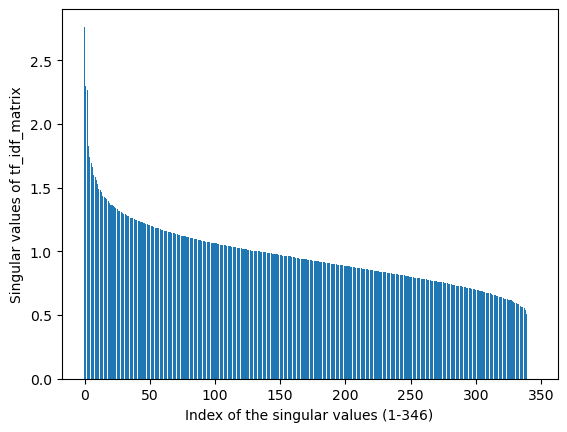

In [83]:
plt.bar([n for n in range(len(svd_test.singular_values_))], height = svd_test.singular_values_)
plt.xlabel("Index of the singular values (1-346)")
plt.ylabel("Singular values of tf_idf_matrix")

Text(0, 0.5, 'Singular values of tf_idf_matrix')

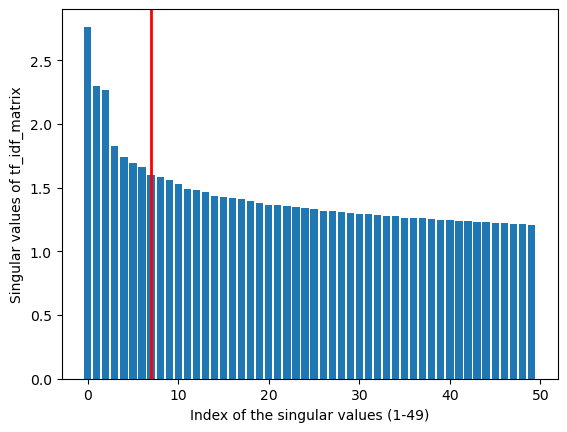

In [84]:
plt.bar([n for n in range(len(svd_test.singular_values_))[:50]], height = svd_test.singular_values_[:50])
plt.axvline(x = 7, color = 'r', linestyle = '-', linewidth = 2)
plt.xlabel("Index of the singular values (1-49)")
plt.ylabel("Singular values of tf_idf_matrix")

### Discuss math of low rank approximation and TruncatedSVD

I want to emphasize this idea that singular values come in order of importance. Assume each of the following letters have subscripts 1: $\sigma$uv. This first piece has the first singular value and its corresponding left and right singular vector. We would say that this is the closest rank one matrix to A (our tf_idf_matrix). In other words if we wanted to use only one singular vector to approximate as much of A as possible, we would choose the combination from the previous sentence. In Gil Strang's textbook *Learning From Data* he states **the sum of the first k pieces is best possible for rank k.** Since I observed a stabilization of singular values around singular value # 7, using the language of Gil Strang, the sum of the first seven pieces gives us a rank-seven matrix that best approximates A (tf_idf_matrix). 

To add some rigor to low rank approximations we introduce the crucial theorem. The Eckart-Young Theorem states: "If B has rank k then ||A - A_k|| ≤ ||A - B||." The intuitive way to understand this is, we can approximate our original matrix A with a lower rank version and it will have a smaller norm than choosing another matrix with the same k rank. This theorem is why we take low rank approximations of A itself instead of trying to find another matrix to approximate it. 

Just like we understood what was happening with the `TfidfVectorizer` we now have an understanding of singular values (math and visual) and the main theorem and intuition for low rank approximations. I introduced this intuition because the [TruncatedSVD class](https://scikit-learn.org/stable/modules/decomposition.html#choice-of-solver-for-kernel-pca) we have been using implements a low rank approximation. You now understand how it works. 

Lastly you may be wondering why take an approximation at all? Why not use all the components from the SVD?

I am going to use a [fantiastic online example](https://saturncloud.io/blog/what-is-sklearn-pca-explained-variance-and-explained-variance-ratio-difference/#:~:text=Explained%20variance%20ratio%20is%20a,of%20all%20the%20principal%20components.) to provide my hypothesis. This example discusses PCA and plots the explained variance ratio. This ratio tells us the proportion of total variance in the data that is explained by the principal components. Furthermore the author calculated the cumulative explained variance ratio which gives us the total amount of expained variance at specific points. At principal component 14 of 17.5 it looks like all the variance in the data can be explained by those components. If we cared about 80% of the variance explained we could choose the top 5 principal components of 17.5. So, if we know we can explain some acceptable amount of variance from a much smaller matrix of our data we can use a low rank approximation to only get those values instead of doing these memory intensive computations on our original matrix when we know all of the data isn't useful. 

---
Let's now return to our original objective: latent semantic analysis. When we decompose the tf_idf_matrix into U, ∑, and V the entries in the U matrix (A * A^T) represent the relationship between documents and the V matrix (A^T * A) represents the relationship between words across documents. For latent semantic analysis we will be more interested in V since this will help us understand the topics (words that co-occur) latent to our texts.

In [9]:
# Choose 100 for n_components
hundred_svd = TruncatedSVD(n_components=100)
hundred_lsa = hundred_svd.fit_transform(tf_idf_matrix)

**Quick note:** Even though we saw earlier that choosing k=7 may be best I've chosen k=2 because we can visualize the results in the xy-plane. 

In [10]:
two_svd = TruncatedSVD(n_components = 2)
two_lsa = two_svd.fit_transform(tf_idf_matrix)

In [11]:
two_svd.singular_values_

array([2.76273878, 2.29453171])

In [12]:
hundred_svd.singular_values_[:2]

array([2.76274018, 2.2945565 ])

In [13]:
topic_encoded_df = pd.DataFrame(two_lsa, columns = ['Topic 1', 'Topic 2'])
topic_encoded_df['Sentence'] = concat_df.Sentence
topic_encoded_df['Is_StPatricks'] = (concat_df.Title == "20 Best St. Patrick’s Day Team Building Activities for Work")
display(topic_encoded_df)

,Topic 1,Topic 2,Sentence,Is_StPatricks
0,0.003803,0.068485,Donald Trump may be a path-breaking politician...,False
1,0.011454,0.015028,He often promises to revive the trade agenda o...,False
2,0.012862,0.228048,"And, during his 2024 campaign, Trump repeatedl...",False
3,0.005408,0.098616,Even Trump has acknowledged that last one is a...,False
4,0.006985,0.117865,"“A very moderate man,” Trump said last weekend...",False
...,...,...,...,...
341,0.461219,-0.009377,These 20 St. Patrick’s Day team-building activ...,True
342,0.238335,-0.029270,From festive competitions to cultural explorat...,True
343,0.299011,0.032785,Celebrating St. Patrick’s Day with coworkers i...,True
344,0.239355,-0.002291,As we reflect on these team-building tips and ...,True


### Discuss importance of the encoding matrix

Gives us items in "term space" so we can see the terms that explain most of the "variance in the data" -- what does that actually mean?

In [15]:
encoding_matrix = pd.DataFrame(two_svd.components_, index = ['topic_1', 'topic_2']).T

encoding_matrix["terms"] = dictionary
display(encoding_matrix)

,topic_1,topic_2,terms
0,1.339645e-03,0.019759,000
1,2.314974e-04,0.002519,100
2,3.188397e-03,0.008200,11
3,4.092462e-03,0.007675,15
4,5.349032e-04,0.004481,166
...,...,...,...
1978,1.989678e-02,0.014539,year
1979,6.934354e-03,0.024362,years
1980,4.203233e-04,0.009594,york
1981,1.987239e-04,0.005001,yunseo


In [16]:
encoding_matrix['abs_topic_1'] = np.abs(encoding_matrix['topic_1'])
encoding_matrix['abs_topic_2'] = np.abs(encoding_matrix['topic_2'])
display(encoding_matrix.sort_values('abs_topic_1', ascending=False).head(25))

,topic_1,topic_2,terms,abs_topic_1,abs_topic_2
487,0.423607,0.057251,day,0.423607,0.057251
1312,0.367297,0.024385,patrick,0.367297,0.024385
1687,0.366497,0.023661,st,0.366497,0.023661
1765,0.342728,-0.074968,team,0.342728,0.074968
250,0.308098,-0.078885,building,0.308098,0.078885
67,0.178713,-0.010526,activities,0.178713,0.010526
68,0.148766,0.011426,activity,0.148766,0.011426
232,0.140286,-0.181484,book,0.140286,0.181484
512,0.140286,-0.181484,demo,0.140286,0.181484
969,0.132810,-0.007459,interested,0.132810,0.007459


In [17]:
encoding_matrix['abs_topic_1'] = np.abs(encoding_matrix['topic_1'])
encoding_matrix['abs_topic_2'] = np.abs(encoding_matrix['topic_2'])
display(encoding_matrix.sort_values('abs_topic_2', ascending=False).head(25))

,topic_1,topic_2,terms,abs_topic_1,abs_topic_2
919,0.016599,0.413420,immigration,0.016599,0.413420
1843,0.018217,0.312743,trump,0.018217,0.312743
174,0.009533,0.239727,attorneys,0.009533,0.239727
1060,0.009156,0.219621,legal,0.009156,0.219621
77,0.012547,0.195950,administration,0.012547,0.195950
232,0.140286,-0.181484,book,0.140286,0.181484
512,0.140286,-0.181484,demo,0.140286,0.181484
729,0.005114,0.117120,federal,0.005114,0.117120
1576,0.009084,0.112676,said,0.009084,0.112676
1076,0.010691,0.112653,like,0.010691,0.112653


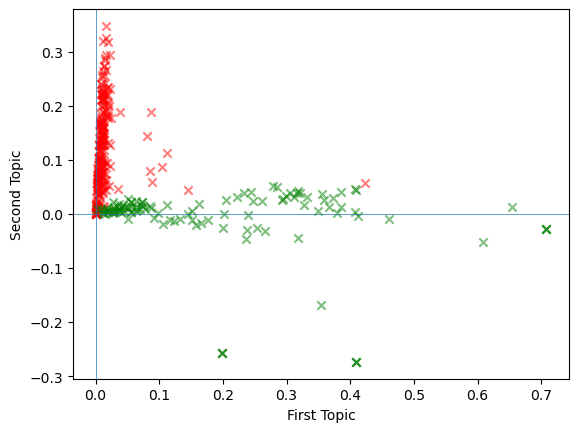

In [18]:
fig, ax = plt.subplots()

# I believe this should print trump in topic_1
for val in topic_encoded_df.Is_StPatricks.unique():
    topic_1 = topic_encoded_df[topic_encoded_df.Is_StPatricks == val]['Topic 1'].values
    topic_2 = topic_encoded_df[topic_encoded_df.Is_StPatricks == val]['Topic 2'].values
    color = "green" if val else "red" # if val means True
    label = "St Patricks" if val else "Trump Articles"
    ax.scatter(topic_1, topic_2, c = color, marker = 'x', alpha = 0.5, label = label)
    
ax.set_xlabel('First Topic')
ax.set_ylabel('Second Topic')
ax.axvline(linewidth = 0.5)
ax.axhline(linewidth = 0.5)

In [19]:
topic_encoded_df['abs_topic_1'] = np.abs(topic_encoded_df['Topic 1'])
display(topic_encoded_df.sort_values('abs_topic_1', ascending = False))

,Topic 1,Topic 2,Sentence,Is_StPatricks,abs_topic_1
261,0.708146,-0.028191,Interested in trying out these team building a...,True,0.708146
294,0.708146,-0.028191,Interested in trying out these team building a...,True,0.708146
323,0.708146,-0.028191,Interested in trying out these team building a...,True,0.708146
270,0.654177,0.012270,This St. Patrick’s Day team-building fosters a...,True,0.654177
244,0.608615,-0.051736,This team-building activity promotes camarader...,True,0.608615
...,...,...,...,...,...
38,0.000115,0.000050,Several dramatic steps appear to be in the works.,False,0.000115
170,0.000017,0.000235,These are not acts of subversion.,False,0.000017
231,0.000007,0.000024,Shame on you.,False,0.000007
163,0.000002,-0.000078,There’s nothing suspicious about that—any more...,False,0.000002


In [20]:
topic_encoded_df['abs_topic_2'] = np.abs(topic_encoded_df['Topic 2'])
display(topic_encoded_df.sort_values('abs_topic_2', ascending = False))

,Topic 1,Topic 2,Sentence,Is_StPatricks,abs_topic_1,abs_topic_2
118,0.015742,0.347532,"This week, Trump escalated his campaign agains...",False,0.015742,0.347532
157,0.015680,0.324752,"Like all attorneys, immigration lawyers are ta...",False,0.015680,0.324752
188,0.012045,0.319652,Immigration attorneys need access to detention...,False,0.012045,0.319652
146,0.019599,0.317975,These are the attorneys who represent clients ...,False,0.019599,0.317975
145,0.021957,0.293820,Trump’s latest action lays the groundwork for ...,False,0.021957,0.293820
...,...,...,...,...,...,...
163,0.000002,-0.000078,There’s nothing suspicious about that—any more...,False,0.000002,0.000078
38,0.000115,0.000050,Several dramatic steps appear to be in the works.,False,0.000115,0.000050
211,0.000002,-0.000033,"In 2022, Representative Zoe Lofgren introduced...",False,0.000002,0.000033
231,0.000007,0.000024,Shame on you.,False,0.000007,0.000024
